# Evaluating Model Performance
We will evaluate and compare the performance of the models using the following metrics:
- Accuracy
- Precision
- Recall


In [42]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function to load a model
def load_model(model_path):
    return keras.models.load_model(model_path)

Found 974 images belonging to 47 classes.

Evaluating model: VGG16
31/31 [==============================] - 18s 573ms/step
Accuracy: 0.075
Top-3 Accuracy: 0.132
Top-5 Accuracy: 0.206
F1 Score: 0.025


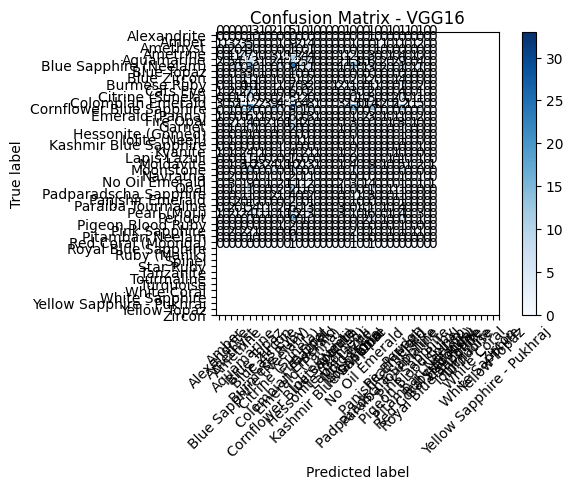

In [44]:
# Configuration
data_dir = "../dat/images"  # Path to your image dataset
model_dir = "../mod/"  # Path to where the saved models are
target_size = (224, 224)
batch_size = 32

validation_split = 0.02  # Percentage of data to use for validation

datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' 
)

# Evaluation
model_paths = [os.path.join(model_dir, file) for file in os.listdir(model_dir) if file.endswith('.h5')]

for model_path in model_paths:
    model_name = os.path.splitext(os.path.basename(model_path))[0] 
    model = load_model(model_path)

    print(f"\nEvaluating model: {model_name}")

    # Predictions
    y_pred = model.predict(val_data)
    y_pred_single = np.argmax(y_pred, axis=1)
    y_true = val_data.classes

    labels =list(val_data.class_indices.values())

    # Metrics
    accuracy = accuracy_score(y_true, y_pred_single)
    top_3_accuracy = top_k_accuracy_score(y_true, y_pred, k=3, labels=labels)
    top_5_accuracy = top_k_accuracy_score(y_true, y_pred, k=5, labels=labels)
    # Macro-Averaged F1 Score
    f1_score = f1_score(y_true, y_pred_single, average='macro')

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Top-3 Accuracy: {top_3_accuracy:.3f}")
    print(f"Top-5 Accuracy: {top_5_accuracy:.3f}")
    print(f"F1 Score: {f1_score:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_single)
    plot_confusion_matrix(cm, classes=val_data.class_indices, title=f'Confusion Matrix - {model_name}')
    plt.show()